In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import RepeatVector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.decomposition import PCA

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
tf.random.set_seed(8) # fix random seed for reproducibility

Num GPUs Available:  1


In [2]:
# Global param
Y_COL = 1
FEATURE_NUMBER = 2
DATA_LOCATION = "../Data/20230625-Data_for_ML"
DATA_FILE_NAME = "Data_for_ML_TT-DB5-2-1"
MODEL_LOCATION = "../Model"
SAVE_MODEL_LOCATION = f"{MODEL_LOCATION}/{DATA_FILE_NAME}"
# Hyperparameter
TRAIN_TEST_RATIO = 0.8
TIME_STEP = 10
# MODEL_TYPE = "CNN_SSO_9"
MODEL_TYPE = "CNN_LSTM_DNN_SSO"
EPOCH_SIZE = 1000
BATCH_SIZE = 2
MODEL_JSON = {}
MIN_DELTA = 0.0001
PATIENCE = 15
# X = [11, 2, 1, 1, 17, 1, 1, 1, 36]
X = [41,2,1,1,16,1,1,1,864]
# X = [8,2,1,1,5,1,1,1,931]
# X = [15,2,1,1,51,1,1,1,122]
# X = [7,2,1,1,98,1,1,1,55]
# X = [4,2,1,1,90,1,1,1,328]
CNN_LSTM = [2,2,1,248,257,51,8]
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=MIN_DELTA,
    patience=PATIENCE,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


def to_string():
    print_list = [
        f"Time step: {TIME_STEP}",
        f"Ratio: {TRAIN_TEST_RATIO}",
        f"Model type: {MODEL_TYPE}",
        f"Epoch size: {EPOCH_SIZE}",
        f"Batch size: {BATCH_SIZE}",
        f"Early stop patience: {PATIENCE}, min delta: {MIN_DELTA}",
        f"Model json: {MODEL_JSON}",
    ]
    return "\n".join(print_list)

mean 4.002189712844084e-05
std 0.00010991307627982778
counts [7348.34663982  328.41772692  143.68275553   41.05221586   20.52610793
   20.52610793   20.52610793   20.52610793   20.52610793]
counts_number [358  16   7   2   1   1   1   1   1]
bin_dataset [6.57871782e-08 1.25628782e-04 2.51191777e-04 3.76754772e-04
 5.02317767e-04 6.27880762e-04 7.53443757e-04 8.79006752e-04
 1.00456975e-03 1.13013274e-03]


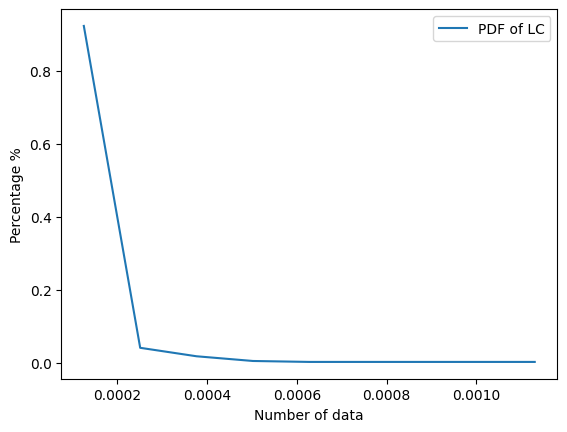

In [3]:
# Load data
dataframe = pd.read_excel(
    f"{DATA_LOCATION}/{DATA_FILE_NAME}.xlsx",
    sheet_name="Sheet1",
    header=1,
    usecols=[0, 4],
)
dataset = dataframe.values
# # Preprocessing
for i in range(dataset.shape[0]):
    dataset[i][0] = int(dataset[i][0].replace("TT", "").replace("'", ""))
# dataset[np.isnan(dataset)] = 0
dataset = dataset.astype("float64")
new_dataset = np.array(np.zeros((1, FEATURE_NUMBER)))
j = 0
mean = np.mean(dataset[:, Y_COL])
print("mean", mean)
standard_deviation = np.std(dataset[:, Y_COL])
print("std", standard_deviation)

bins_size = int(1 + 3.3 * np.log10(len(dataset)))
counts, bin_dataset = np.histogram(dataset[:, Y_COL], bins=bins_size, density=True)
counts_number, bin_dataset = np.histogram(dataset[:, Y_COL], bins=bins_size)
rel_freq = counts_number / len(dataset)
print("counts", counts)
print("counts_number", counts_number)
print("bin_dataset", bin_dataset)
plt.clf()
plt.plot(bin_dataset[1:], rel_freq, label="PDF of LC")
plt.xlabel("Number of data")
plt.ylabel("Percentage %")
plt.legend()
plt.show()

# Take 95% of the data and by interval
for i in range(dataset.shape[0]):
    #     if dataset[i][0] < 50 and dataset[i][0] < 90:
    if (
        dataset[i][Y_COL] > mean - 2 * standard_deviation
        and dataset[i][Y_COL] < mean + 2 * standard_deviation
    ):
        new_dataset = np.append(new_dataset, [dataset[i]], axis=0)
        j += 1
dataset = new_dataset[1:, :]

# cumulative dataset
# for i in range(1, dataset.shape[0]):
#     dataset[i, Y_COL] = dataset[i - 1, Y_COL] + dataset[i, Y_COL]
    # dataset[i] = dataset[i-1] + dataset[i]

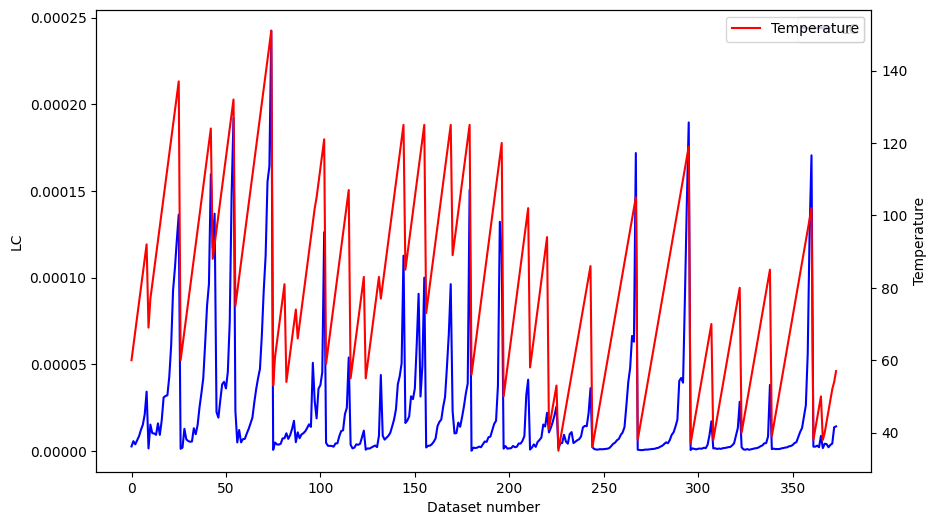

In [4]:
# Plot data
plt.figure(figsize=(10,6))
plt.plot(dataset[:,Y_COL], color="blue", label="LC")
plt.xlabel("Dataset number")
plt.ylabel("LC")
leg = plt.legend()
plt.twinx()
plt.ylabel("Temperature")
plt.plot(dataset[:,0], color="red", label="Temperature")
leg = plt.legend()
plt.rcParams.update({'font.size': 10})
plt.show()

In [5]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

In [6]:
# split into train and test sets
train_size = int(len(dataset) * TRAIN_TEST_RATIO)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(f"Total : {len(dataset)}, Train: {len(train)}, Test: {len(test)}")

Total : 374, Train: 299, Test: 75


In [7]:
# pca to reduce features
# pca = PCA(n_components = 2)
# FEATURE_NUMBER = 2
# train_x = pca.fit_transform(train)
# test_x = pca.transform(test)
# # normalize x
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)
# print(train_x.shape)
# print(test_x.shape)

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, y_col=Y_COL):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, y_col])
	return np.array(dataX), np.array(dataY)

In [9]:
# reshape into X=t and Y=t+1
# train_x, train_y = create_dataset(train, TIME_STEP)
# test_x, test_y = create_dataset(test, TIME_STEP)
train_x = scaler.fit_transform(train)
test_x = scaler.transform(test)
train_x, _ = create_dataset(train_x, TIME_STEP)
test_x, _ = create_dataset(test_x, TIME_STEP)
_, train_y = create_dataset(train, TIME_STEP,Y_COL)
_, test_y = create_dataset(test, TIME_STEP,Y_COL)
# normalize y 
# train_y = train_y.reshape(-1,1)
# test_y = test_y.reshape(-1,1)
train_y = scaler.fit_transform(train_y.reshape(-1,1))
test_y = scaler.transform(test_y.reshape(-1,1))

In [10]:
# reshape input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], TIME_STEP, FEATURE_NUMBER))
test_x = np.reshape(test_x, (test_x.shape[0], TIME_STEP, FEATURE_NUMBER))

In [11]:
# create and fit the LSTM network
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model = Sequential()
if MODEL_TYPE == "LSTM":
    model.add(LSTM(32, input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True))
    model.add(LSTM(32, input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN":
    model.add(
        Conv1D(32, (2), activation="relu", input_shape=(TIME_STEP, FEATURE_NUMBER))
    )
    model.add(Conv1D(16, (2), activation="relu"))
    model.add(Conv1D(8, (1), activation="relu"))
    model.add(MaxPooling1D((2)))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_SSO_9":
    model.add(
        Conv1D(
            X[0],
            kernel_size=(int(X[1])),
            strides=(int(X[2])),
            input_shape=(TIME_STEP, FEATURE_NUMBER),
            padding="valid",
            activation="relu",
            kernel_initializer="uniform",
        )
    )
    model.add(MaxPooling1D(pool_size=(int(X[3]))))
    model.add(
        Conv1D(
            X[4],
            (int(X[5])),
            strides=(int(X[6])),
            padding="valid",
            activation="relu",
            kernel_initializer="uniform",
        )
    )
    # X[12], X[13] = 2, 2
    model.add(MaxPooling1D(pool_size=(int(X[7]))))
    # X[14], X[15] = 100, 10
    model.add(Flatten())
    model.add(Dense(X[8], activation="relu"))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_SSO":
    model.add(
        Conv1D(
            X[0],
            kernel_size=(int(X[1])),
            strides=(int(X[3])),
            input_shape=(TIME_STEP, FEATURE_NUMBER),
            padding="valid",
            activation="relu",
            kernel_initializer="uniform",
        )
    )
    model.add(MaxPooling1D(pool_size=(int(X[5]))))
    model.add(
        Conv1D(
            X[7],
            (int(X[8])),
            strides=(int(X[10])),
            padding="valid",
            activation="relu",
            kernel_initializer="uniform",
        )
    )
    # X[12], X[13] = 2, 2
    model.add(MaxPooling1D(pool_size=(int(X[12]))))
    # X[14], X[15] = 100, 10
    model.add(Flatten())
    model.add(Dense(X[14], activation="relu"))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM":
    model.add(
        Conv1D(6, (2), activation="relu", input_shape=(TIME_STEP, FEATURE_NUMBER))
    )
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM_DNN_SSO":
    model.add(
        Conv1D(CNN_LSTM[0], kernel_size=CNN_LSTM[1], strides=CNN_LSTM[2], activation="relu", input_shape=(TIME_STEP, FEATURE_NUMBER))
    )
    model.add(LSTM(CNN_LSTM[3], "relu", return_sequences=True))
    model.add(LSTM(CNN_LSTM[4], "relu"))
    model.add(Dense(CNN_LSTM[5]))
    model.add(Dense(CNN_LSTM[6]))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM_DNN":
    model.add(
        Conv1D(8, (2), activation="relu", input_shape=(TIME_STEP, FEATURE_NUMBER))
    )
    model.add(LSTM(32, "relu", return_sequences=True))
    model.add(LSTM(32, "relu"))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM_DNN2":
    model.add(
        Conv1D(128, (2), activation="relu", input_shape=(TIME_STEP, FEATURE_NUMBER))
    )
    model.add(
        LSTM(
            200, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(LSTM(100, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN":
    model.add(
        LSTM(32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True)
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True)
    )
    model.add(LSTM(32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN2":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(16))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN3":
    model.add(
        LSTM(
            300, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(LSTM(300, "relu"))
    model.add(Dense(32))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN4":
    model.add(
        LSTM(
            300, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(Dropout(0.2))
    model.add(LSTM(300, "relu"))
    model.add(Dense(32))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN5":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(1))
model.summary()
MODEL_JSON = model.to_json()
model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae", "mape"])
model.fit(
    train_x,
    train_y,
    epochs=EPOCH_SIZE,
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=[EARLY_STOPPING, tensorboard_callback],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 2)              10        
                                                                 
 lstm (LSTM)                 (None, 9, 248)            248992    
                                                                 
 lstm_1 (LSTM)               (None, 257)               520168    
                                                                 
 dense (Dense)               (None, 51)                13158     
                                                                 
 dense_1 (Dense)             (None, 8)                 416       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 782,753
Trainable params: 782,753
Non-trai

In [12]:
# save model
version = 0
if not os.path.exists(SAVE_MODEL_LOCATION):
    os.makedirs(SAVE_MODEL_LOCATION)
for dir in os.scandir(f"{SAVE_MODEL_LOCATION}/"):
    if dir.is_dir():
        version = int(dir.name) if int(dir.name) > version else version
version += 1
model.save(f"{SAVE_MODEL_LOCATION}/{version}")

INFO:tensorflow:Assets written to: ../Model/Data_for_ML_TT-DB5-2-1/2\assets


INFO:tensorflow:Assets written to: ../Model/Data_for_ML_TT-DB5-2-1/2\assets


[0.009907855652272701, 0.009907855652272701, 0.034788068383932114, 158.00994873046875]
2/2 [==============================] - 0s 8ms/step
Train MSE Score: 0.0000000008 MSE
Test MSE Score: 0.0000000006 MSE
Train MAE Score: 0.0000146376 MAE
Test MAE Score: 0.0000084327 MAE
Train MAPE Score: 7.4494 MAPE
Test MAPE Score: 1.5030 MAPE
Train RMSE Score: 0.0000277953 RMSE
Test RMSE Score: 0.0000241282 RMSE
Train RMSPE: 79.2051 RMSPE
Test RMSPE: 2.2534 RMSPE


<Figure size 640x480 with 0 Axes>

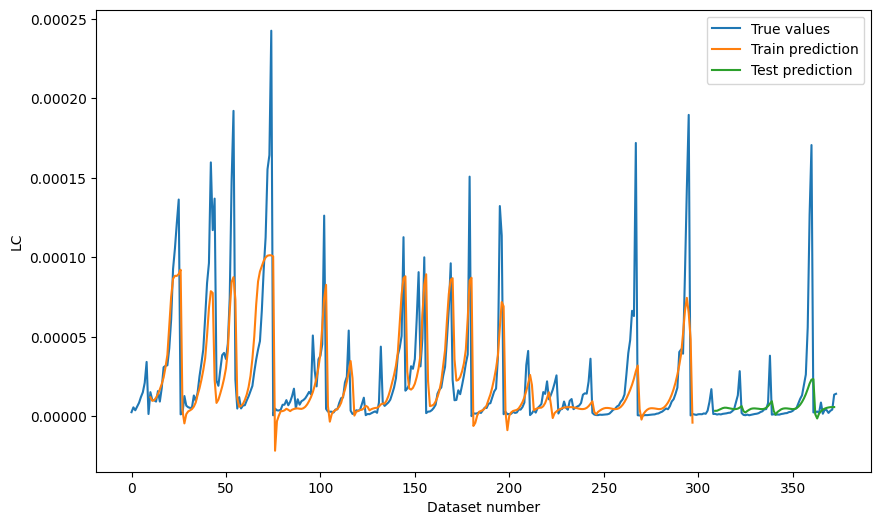

In [13]:
# predictions
score = model.evaluate(test_x, test_y,batch_size=20, verbose=0)  # return MAPE
print(score)
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
train_true = scaler.inverse_transform(train_y).reshape(1, -1)
test_predict = scaler.inverse_transform(test_predict)
test_true = scaler.inverse_transform(test_y).reshape(1, -1)

# scaled
# train_predict = train_predict
# train_true = np.reshape(train_y,(1,-1))
# test_predict = test_predict
# test_true = np.reshape(test_y,(1,-1))

# calculate mean absolute error (MAE)
train_mae = mean_absolute_error(train_true[0], train_predict[:, 0])
test_mae = mean_absolute_error(test_true[0], test_predict[:, 0])
# calculate mean absolute percentage error (MAPE)
train_mape = mean_absolute_percentage_error(train_true[0], train_predict[:, 0])
test_mape = mean_absolute_percentage_error(test_true[0], test_predict[:, 0])
# calculate mean squared error (MSE)
train_mse = mean_squared_error(train_true[0], train_predict[:, 0])
test_mse = mean_squared_error(test_true[0], test_predict[:, 0])
# calculate root mean squared error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
# calculate root mean squared percentage error (RMSPE)
train_rmspe = np.sqrt(
    np.mean(
        np.square(((train_true[0] - train_predict[:, 0]) / train_true[0])),
        axis=0,
    )
)
test_rmspe = np.sqrt(
    np.mean(
        np.square(((test_true[0] - test_predict[:, 0]) / test_true[0])),
        axis=0,
    )
)

train_mse_output = "Train MSE Score: %.10f MSE" % train_mse
test_mse_output = "Test MSE Score: %.10f MSE" % test_mse
train_mae_output = "Train MAE Score: %.10f MAE" % train_mae
test_mae_output = "Test MAE Score: %.10f MAE" % test_mae
train_mape_output = "Train MAPE Score: %.4f MAPE" % train_mape
test_mape_output = "Test MAPE Score: %.4f MAPE" % test_mape
train_rmse_output = "Train RMSE Score: %.10f RMSE" % train_rmse
test_rmse_output = "Test RMSE Score: %.10f RMSE" % test_rmse
train_rmspe_output = "Train RMSPE: %.4f RMSPE" % train_rmspe
test_rmspe_output = "Test RMSPE: %.4f RMSPE" % test_rmspe
print(train_mse_output)
print(test_mse_output)
print(train_mae_output)
print(test_mae_output)
print(train_mape_output)
print(test_mape_output)
print(train_rmse_output)
print(test_rmse_output)
print(train_rmspe_output)
print(test_rmspe_output)

rmse_file = open(f"./{SAVE_MODEL_LOCATION}/{version}/info.md", "w")
rmse_file.write(
    train_mse_output
    + "\n"
    + test_mse_output
    + "\n"
    + train_mae_output
    + "\n"
    + test_mae_output
    + "\n"
    + train_mape_output
    + "\n"
    + test_mape_output
    + "\n"
    + train_rmse_output
    + "\n"
    + test_rmse_output
    + "\n"
    + train_rmspe_output
    + "\n"
    + test_rmspe_output
)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:, Y_COL]).reshape(-1, 1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[TIME_STEP : len(train_predict) + TIME_STEP, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:, Y_COL]).reshape(-1, 1)
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(train_predict) + (TIME_STEP * 2) + 1 : len(dataset) - 1, :
] = test_predict

true_values = (dataset)[:, Y_COL].reshape(-1, 1)
# plot baseline and predictions
plt.clf()
plt.figure(figsize=(10, 6))
plt.rcParams.update({"font.size": 10})
plt.xlabel("Dataset number")
plt.ylabel("LC")
plt.plot(true_values, label="True values")
# plt.plot(test_true.reshape(-1,1), label="Test true")
plt.plot(trainPredictPlot, label="Train prediction")
plt.plot(testPredictPlot, label="Test prediction")
leg = plt.legend()

plt.savefig(f"{SAVE_MODEL_LOCATION}/{version}/predict_normal.png")
plt.show()
# for i in range(1, train_predict):
#     train_predict[i] = train_predict[i - 1] + train_predict[i]
# for i in range(1, train_true):
#     train_true[i] = train_true[i - 1] + train_true[i]
# for i in range(1, test_predict):
#     test_predict[i] = test_predict[i - 1] + test_predict[i]
# for i in range(1, test_true):
#     test_true[i] = test_true[i - 1] + test_true[i]

In [14]:
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
train_true = scaler.inverse_transform(train_y).reshape(1, -1)
test_predict = scaler.inverse_transform(test_predict)
test_true = scaler.inverse_transform(test_y).reshape(1, -1)

true_values = np.cumsum((dataset)[:,Y_COL].reshape(-1,1))

train_true = np.cumsum(train_true).reshape(1, -1)
test_true = true_values[-len(test_true[0]):].reshape(1,-1)

train_predict = np.cumsum(train_predict).reshape(-1, 1)
test_predict = np.cumsum(np.append(test_true[0, 0], test_predict))[1:].reshape(-1, 1)
# test_predict = np.cumsum(test_predict).reshape(-1, 1)


# calculate mean absolute error (MAE)
train_mae = mean_absolute_error(train_true[0], train_predict[:, 0])
test_mae = mean_absolute_error(test_true[0], test_predict[:, 0])
# calculate mean absolute percentage error (MAPE)
train_mape = mean_absolute_percentage_error(train_true[0], train_predict[:, 0])
test_mape = mean_absolute_percentage_error(test_true[0], test_predict[:, 0])
# calculate mean squared error (MSE)
train_mse = mean_squared_error(train_true[0], train_predict[:, 0])
test_mse = mean_squared_error(test_true[0], test_predict[:, 0])
# calculate root mean squared error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
# calculate root mean squared percentage error (RMSPE)
train_rmspe = np.sqrt(
    np.mean(
        np.square(((train_true[0] - train_predict[:, 0]) / train_true[0])),
        axis=0,
    )
)
test_rmspe = np.sqrt(
    np.mean(
        np.square(((test_true[0] - test_predict[:, 0]) / test_true[0])),
        axis=0,
    )
)

train_mse_output = "Train MSE Score: %.10f MSE" % train_mse
test_mse_output = "Test MSE Score: %.10f MSE" % test_mse
train_mae_output = "Train MAE Score: %.10f MAE" % train_mae
test_mae_output = "Test MAE Score: %.10f MAE" % test_mae
train_mape_output = "Train MAPE Score: %.4f MAPE" % train_mape
test_mape_output = "Test MAPE Score: %.4f MAPE" % test_mape
train_rmse_output = "Train RMSE Score: %.10f RMSE" % train_rmse
test_rmse_output = "Test RMSE Score: %.10f RMSE" % test_rmse
train_rmspe_output = "Train RMSPE: %.4f RMSPE" % train_rmspe
test_rmspe_output = "Test RMSPE: %.4f RMSPE" % test_rmspe
print(train_mse_output)
print(test_mse_output)
print(train_mae_output)
print(test_mae_output)
print(train_mape_output)
print(test_mape_output)
print(train_rmse_output)
print(test_rmse_output)
print(train_rmspe_output)
print(test_rmspe_output)

rmse_file = open(f"./{SAVE_MODEL_LOCATION}/{version}/info.md", "a")
rmse_file.write(
    "\n\nCumulative:\n"
    + train_mse_output
    + "\n"
    + test_mse_output
    + "\n"
    + train_mae_output
    + "\n"
    + test_mae_output
    + "\n"
    + train_mape_output
    + "\n"
    + test_mape_output
    + "\n"
    + train_rmse_output
    + "\n"
    + test_rmse_output
    + "\n"
    + train_rmspe_output
    + "\n"
    + test_rmspe_output
    + "\n\n"
    + to_string()
)
rmse_file.close()

2/2 [==============================] - 0s 7ms/step
Train MSE Score: 0.0000002759 MSE
Test MSE Score: 0.0000000184 MSE
Train MAE Score: 0.0004825806 MAE
Test MAE Score: 0.0000772099 MAE
Train MAPE Score: 0.1165 MAPE
Test MAPE Score: 0.0094 MAPE
Train RMSE Score: 0.0005252964 RMSE
Test RMSE Score: 0.0001357093 RMSE
Train RMSPE: 0.1311 RMSPE
Test RMSPE: 0.0163 RMSPE


(374,)
(374, 1)


<Figure size 640x480 with 0 Axes>

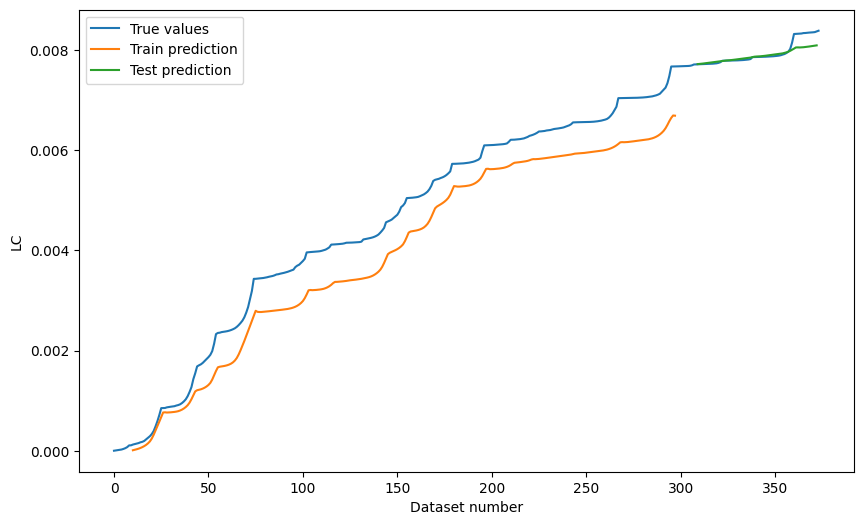

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:,Y_COL]).reshape(-1,1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[TIME_STEP:len(train_predict)+TIME_STEP, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:,Y_COL]).reshape(-1,1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(TIME_STEP*2)+1:len(dataset)-1, :] = test_predict

true_values = np.cumsum((dataset)[:,Y_COL].reshape(-1,1))
print(true_values.shape)
print(trainPredictPlot.shape)
# plot baseline and predictions
plt.clf()
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 10})
plt.xlabel("Dataset number")
plt.ylabel("LC")
plt.plot(true_values, label="True values")
# plt.plot(test_true.reshape(-1,1), label="Test true")
plt.plot(trainPredictPlot, label="Train prediction")
plt.plot(testPredictPlot, label="Test prediction")
leg = plt.legend()

plt.savefig(f"{SAVE_MODEL_LOCATION}/{version}/predict_cumulative.png")
plt.show()